# Introduction

By the year of 2011, there were about 20 thousand japanese immigrants living in New York City. According to the 2017 United States Census Bureau, there were 1,466,514 Americans with japanese ancestry living in USA.

The Asian American population is greatly urbanized, with nearly three-quarters of them living in metropolitan areas with population greater than 2.5 million. New York City is one of the three areas with the highest Asian American Populations (Greater Los Angeles Area, New York Metropolitan Area and San Francisco Bay Area).

According to the USA 2010 Census, New York is home to more that one million Asian Americans.
This project will attempt to answer the questions “Where should an investor open a Japanese Restaurant in NYC?” and “Where should I go If I want a great and highly rated Japanese food?”.


# Data

In order to answer the above questions, data on New York City neighborhoods and boroughs, including boundaries, latitude, longitude, restaurants and restaurants ratings are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

All data related to locations and quality of Japanese restaurants will be obtained via the FourSquare API, using the Requests library in Python.


# Methods

Data will be collected from https://cocl.us/new_york_dataset, cleaned and processed into a dataframe. FourSquare will be used to locate all venues and then filtered by Japanese restaurants. Users ratings will be counted and added to the dataframe.

After the data is preprocessed, It will be sorted based on ratings. Finally, It will be visualized using charts from Python libraries and also divided into different clusters, using machine learning K-Means algorithm, from scikit-learn library.


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import os
import folium 
from geopy.geocoders import Nominatim
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans

In [3]:
# Foursquare Credentials

CLIENT_ID = '4VRNT3441DPQWWUYGBLRAX3L5YXKCC2KGKBHESBSWGCHCH5T'
CLIENT_SECRET = 'Q4VUWFLYS3YIIFWFPU1XZ3V41O0V0ECR2NDMN4HUEYNF45VW'
VERSION = '20210312'

In [4]:
# Defining functions for later use

def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [5]:
# Getting NYC data
ny_data = get_new_york_data()
ny_data.head()
ny_data.to_excel('ny_data.xlsx')

In [6]:
# Evaluating data
ny_data.shape

(306, 4)

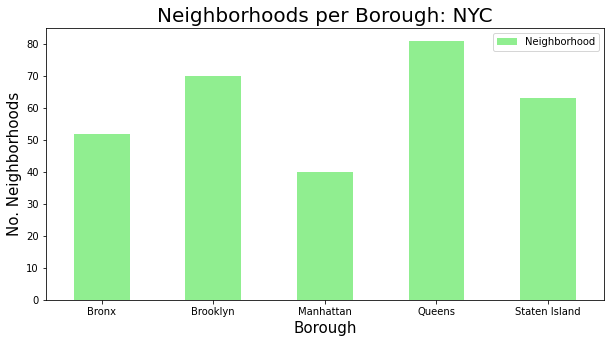

In [7]:
# Analysing the data

clr = "cyan"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color='lightgreen')
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [8]:
# queens has most neighborhoods
# prepare neighborhood list that contains japanese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_restaurants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(ny_data),')','Japanese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(japanese_restaurants)))
    print(row)
    for resturant_detail in japanese_restaurants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Japanese Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Japanese Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Japanese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Japanese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Japanese Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Japanese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Japanese Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Japanese Restaurants in Norwood, B

( 67 / 306 ) Japanese Restaurants in Carroll Gardens, Brooklyn:1
['Brooklyn', 'Carroll Gardens', 40.680540231076485, -73.99465372828006]
( 68 / 306 ) Japanese Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Japanese Restaurants in Gowanus, Brooklyn:0
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Japanese Restaurants in Fort Greene, Brooklyn:1
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Japanese Restaurants in Park Slope, Brooklyn:1
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Japanese Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Japanese Restaurants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Japanese Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758

( 130 / 306 ) Japanese Restaurants in Astoria, Queens:0
['Queens', 'Astoria', 40.76850859335492, -73.91565374304234]
( 131 / 306 ) Japanese Restaurants in Woodside, Queens:1
['Queens', 'Woodside', 40.74634908860222, -73.90184166838284]
( 132 / 306 ) Japanese Restaurants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Japanese Restaurants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Japanese Restaurants in Howard Beach, Queens:1
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Japanese Restaurants in Corona, Queens:0
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Japanese Restaurants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Japanese Restaurants in Kew Gardens, Queens:0
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Japan

( 196 / 306 ) Japanese Restaurants in North Corona, Queens:0
['Queens', 'North Corona', 40.7540709990489, -73.85751790676447]
( 197 / 306 ) Japanese Restaurants in Forest Hills Gardens, Queens:0
['Queens', 'Forest Hills Gardens', 40.7146110815117, -73.8410221123401]
( 198 / 306 ) Japanese Restaurants in St. George, Staten Island:0
['Staten Island', 'St. George', 40.6449815710044, -74.07935312512797]
( 199 / 306 ) Japanese Restaurants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) Japanese Restaurants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Japanese Restaurants in Rosebank, Staten Island:0
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Japanese Restaurants in West Brighton, Staten Island:1
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Japanese Restaurants in Grymes H

ConnectionError: HTTPSConnectionPool(host='api.foursquare.com', port=443): Max retries exceeded with url: /v2/venues/explore?&client_id=4VRNT3441DPQWWUYGBLRAX3L5YXKCC2KGKBHESBSWGCHCH5T&client_secret=Q4VUWFLYS3YIIFWFPU1XZ3V41O0V0ECR2NDMN4HUEYNF45VW&v=20210312&ll=40.61919310792676,-74.09629029235458&radius=400&limit=100 (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x00000198BDD71748>: Failed to establish a new connection: [WinError 10060] Uma tentativa de conexão falhou porque o componente conectado não respondeu\r\ncorretamente após um período de tempo ou a conexão estabelecida falhou\r\nporque o host conectado não respondeu'))

In [9]:
#italian_rest_ny.to_csv('italian_rest_ny.csv')
# Save the information so far to a .csv file due to limited calls on FourSquare
japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv')
japanese_rest_ny.to_excel('japanese_rest_ny_tocsv1.xlsx')

In [137]:
japanese_ny = pd.read_csv('japanese_rest_ny_tocsv1.csv')
japanese_ny

,Unnamed: 0,Borough,Neighborhood,ID,Name
0,0,Brooklyn,Kensington,4d5c12a01e43236a87eb1583,Sake Sushi
1,1,Brooklyn,Prospect Heights,5cb5e5f9a35f4600255406c6,Maison Yaki
2,2,Brooklyn,Williamsburg,51f9b7b3498eefe896caeb23,Shalom Japan
3,3,Brooklyn,Bedford Stuyvesant,5b3bcb69bfc6d0002ca9bf17,Warude
4,4,Brooklyn,Brooklyn Heights,479ccb47f964a5206b4d1fe3,Iron Chef House
5,5,Brooklyn,Cobble Hill,48a41073f964a52091511fe3,Hibino
6,6,Brooklyn,Carroll Gardens,5e4f270b03b7910008721f2e,Karazishi Botan
7,7,Brooklyn,Fort Greene,5739c66c498e7ef6085cec4f,Karasu
8,8,Brooklyn,Park Slope,5276d39a498eb1a5d90096e4,Sushi Katsuei
9,9,Brooklyn,Clinton Hill,4e3cadcb1f6e844231dbe017,Waza


In [138]:
japanese_ny.shape

(69, 5)

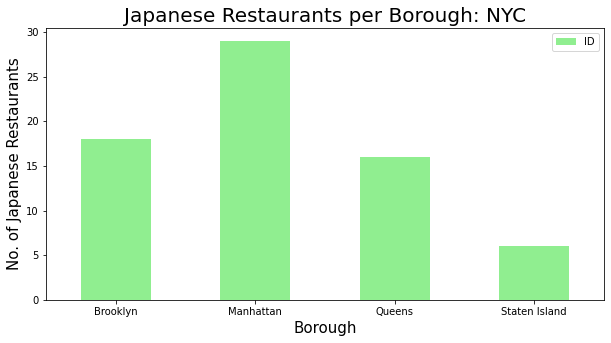

In [139]:
japanese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color='lightgreen')
plt.title('Japanese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [143]:
# Getting the ranking of each restaurant

column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(brazilian_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
japanese_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '604bc791d1563c0334c93880'}, 'response': {'venue': {'id': '4d5c12a01e43236a87eb1583', 'name': 'Sake Sushi', 'contact': {'phone': '7188515299', 'formattedPhone': '(718) 851-5299'}, 'location': {'address': '328 Church Ave', 'crossStreet': 'East 4th Street', 'lat': 40.644138, 'lng': -73.976439, 'labeledLatLngs': [{'label': 'display', 'lat': 40.644138, 'lng': -73.976439}], 'postalCode': '11218', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['328 Church Ave (East 4th Street)', 'Brooklyn, NY 11218', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sake-sushi/4d5c12a01e43236a87eb1583', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 49}, 'url': 'http

{'meta': {'code': 200, 'requestId': '604bc792511b4e7cb60e20b7'}, 'response': {'venue': {'id': '5cb5e5f9a35f4600255406c6', 'name': 'Maison Yaki', 'contact': {'phone': '7185522609', 'formattedPhone': '(718) 552-2609', 'twitter': 'maisonyaki', 'instagram': 'maisonyaki', 'facebook': '272996516936741', 'facebookUsername': 'maisonyaki', 'facebookName': 'Maison Yaki'}, 'location': {'address': '626 Vanderbilt Ave', 'crossStreet': 'Prospect Place', 'lat': 40.67747521328162, 'lng': -73.96908078141962, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67747521328162, 'lng': -73.96908078141962}], 'postalCode': '11238', 'cc': 'US', 'neighborhood': 'Prospect Heights', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['626 Vanderbilt Ave (Prospect Place)', 'Brooklyn, NY 11238', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/maison-yaki/5cb5e5f9a35f4600255406c6', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName

{'meta': {'code': 200, 'requestId': '604bc79297d24e3f5ec16029'}, 'response': {'venue': {'id': '51f9b7b3498eefe896caeb23', 'name': 'Shalom Japan', 'contact': {'phone': '7183884012', 'formattedPhone': '(718) 388-4012', 'twitter': 'shalomjapan'}, 'location': {'address': '310 S 4th St', 'crossStreet': 'at Rodney St', 'lat': 40.709219, 'lng': -73.955839, 'labeledLatLngs': [{'label': 'display', 'lat': 40.709219, 'lng': -73.955839}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['310 S 4th St (at Rodney St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shalom-japan/51f9b7b3498eefe896caeb23', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '52e81612bcbc57f1066b79fd', 'nam

{'meta': {'code': 200, 'requestId': '604bc793923f396233e30cab'}, 'response': {'venue': {'id': '5b3bcb69bfc6d0002ca9bf17', 'name': 'Warude', 'contact': {}, 'location': {'address': '387 Tompkins', 'lat': 40.684409678801586, 'lng': -73.94411847251774, 'labeledLatLngs': [{'label': 'display', 'lat': 40.684409678801586, 'lng': -73.94411847251774}], 'postalCode': '11216', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['387 Tompkins', 'New York, NY 11216', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/warude/5b3bcb69bfc6d0002ca9bf17', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss

{'meta': {'code': 200, 'requestId': '604bc7947bc2ec28def79ed5'}, 'response': {'venue': {'id': '479ccb47f964a5206b4d1fe3', 'name': 'Iron Chef House', 'contact': {'phone': '7188588517', 'formattedPhone': '(718) 858-8517', 'facebook': '115805155108798', 'facebookUsername': 'IronChefHouse', 'facebookName': 'Iron Chef House'}, 'location': {'address': '92 Clark St', 'crossStreet': 'Henry St', 'lat': 40.697405738767394, 'lng': -73.99256031665585, 'labeledLatLngs': [{'label': 'display', 'lat': 40.697405738767394, 'lng': -73.99256031665585}, {'label': 'entrance', 'lat': 40.69726, 'lng': -73.992604}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['92 Clark St (Henry St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/iron-chef-house/479ccb47f964a5206b4d1fe3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName'

{'meta': {'code': 200, 'requestId': '604bc79440460b634608028c'}, 'response': {'venue': {'id': '48a41073f964a52091511fe3', 'name': 'Hibino', 'contact': {'phone': '7182608052', 'formattedPhone': '(718) 260-8052', 'twitter': 'hibino_brooklyn', 'facebook': '301149720034179', 'facebookUsername': 'hibinobklyn', 'facebookName': 'Hibino Brooklyn'}, 'location': {'address': '333 Henry St', 'crossStreet': 'at Pacific St', 'lat': 40.69007601730789, 'lng': -73.99649744997076, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69007601730789, 'lng': -73.99649744997076}, {'label': 'entrance', 'lat': 40.690164, 'lng': -73.996383}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['333 Henry St (at Pacific St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hibino/48a41073f964a52091511fe3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Rest

{'meta': {'code': 200, 'requestId': '604bc7952318c6252237ff08'}, 'response': {'venue': {'id': '5e4f270b03b7910008721f2e', 'name': 'Karazishi Botan', 'contact': {'phone': '3477631155', 'formattedPhone': '(347) 763-1155', 'instagram': 'karazishi_botan', 'facebook': '110365083873021', 'facebookUsername': 'KarazishiBotanBKLYN', 'facebookName': 'Karazishi Botan'}, 'location': {'address': '255 Smith St', 'crossStreet': 'Degraw St', 'lat': 40.683154, 'lng': -73.992888, 'labeledLatLngs': [{'label': 'display', 'lat': 40.683154, 'lng': -73.992888}], 'postalCode': '11231', 'cc': 'US', 'neighborhood': 'Boerum Hill', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['255 Smith St (Degraw St)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/karazishi-botan/5e4f270b03b7910008721f2e', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon'

{'meta': {'code': 200, 'requestId': '604bc79524641a240f9b41d8'}, 'response': {'venue': {'id': '5739c66c498e7ef6085cec4f', 'name': 'Karasu', 'contact': {'phone': '3472234811', 'formattedPhone': '(347) 223-4811'}, 'location': {'address': '166 Dekalb Ave', 'lat': 40.68957739999216, 'lng': -73.97329032514342, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68957739999216, 'lng': -73.97329032514342}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['166 Dekalb Ave', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/karasu/5739c66c498e7ef6085cec4f', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 35}, 'url': 'http://karasubk.com', 'price': {

{'meta': {'code': 200, 'requestId': '604bc7967bc2ec28def7a470'}, 'response': {'venue': {'id': '5276d39a498eb1a5d90096e4', 'name': 'Sushi Katsuei', 'contact': {'phone': '7187885338', 'formattedPhone': '(718) 788-5338', 'instagram': 'sushikatsuei', 'facebook': '566743240069984', 'facebookUsername': 'SushiKatsuei', 'facebookName': 'Sushi Katsuei'}, 'location': {'address': '210 7th Ave', 'crossStreet': 'at 3rd St', 'lat': 40.67061519402922, 'lng': -73.97850388946965, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67061519402922, 'lng': -73.97850388946965}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['210 7th Ave (at 3rd St)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sushi-katsuei/5276d39a498eb1a5d90096e4', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'htt

{'meta': {'code': 200, 'requestId': '604bc7961d22ba42e71af73d'}, 'response': {'venue': {'id': '4e3cadcb1f6e844231dbe017', 'name': 'Waza', 'contact': {'phone': '7183999292', 'formattedPhone': '(718) 399-9292'}, 'location': {'address': '485 Myrtle Ave', 'lat': 40.693487522158414, 'lng': -73.965735666986, 'labeledLatLngs': [{'label': 'display', 'lat': 40.693487522158414, 'lng': -73.965735666986}, {'label': 'entrance', 'lat': 40.693575, 'lng': -73.965731}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['485 Myrtle Ave', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/waza/4e3cadcb1f6e844231dbe017', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'ti

{'meta': {'code': 200, 'requestId': '604bc79767449f0c9d0848d4'}, 'response': {'venue': {'id': '5946d138e2da1964625ca9b2', 'name': 'Daigo Hand Roll Bar', 'contact': {}, 'location': {'address': '445 Albee Sq W', 'lat': 40.69125894731662, 'lng': -73.98260299755893, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69125894731662, 'lng': -73.98260299755893}], 'postalCode': '11201', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['445 Albee Sq W', 'New York, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/daigo-hand-roll-bar/5946d138e2da1964625ca9b2', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 12}, 'url': 'https://www.daigohandrollbar.com', 'price': {'tier': 2, 'messag

{'meta': {'code': 200, 'requestId': '604bc79769f3fa7a575910e3'}, 'response': {'venue': {'id': '58a202a25490d30f87553a08', 'name': 'Rice & Miso', 'contact': {'phone': '9292793488', 'formattedPhone': '(929) 279-3488', 'twitter': 'riceandmiso', 'instagram': 'riceandmisoeveryday'}, 'location': {'address': '134 Nevins St', 'lat': 40.68463349074915, 'lng': -73.9837684857605, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68463349074915, 'lng': -73.9837684857605}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['134 Nevins St', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rice--miso/58a202a25490d30f87553a08', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 

{'meta': {'code': 200, 'requestId': '604bc7981d22ba42e71afb82'}, 'response': {'venue': {'id': '4c7f0887fb74236a7727f9b9', 'name': 'Samurai Mama', 'contact': {'phone': '7185996161', 'formattedPhone': '(718) 599-6161'}, 'location': {'address': '205 Grand St', 'crossStreet': 'btwn Bedford & Driggs Ave', 'lat': 40.71411421938972, 'lng': -73.96019631848635, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71411421938972, 'lng': -73.96019631848635}, {'label': 'entrance', 'lat': 40.714135, 'lng': -73.960149}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['205 Grand St (btwn Bedford & Driggs Ave)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/samurai-mama/4c7f0887fb74236a7727f9b9', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/f

{'meta': {'code': 200, 'requestId': '604bc798b2d4e616c5fd655a'}, 'response': {'venue': {'id': '51f9b7b3498eefe896caeb23', 'name': 'Shalom Japan', 'contact': {'phone': '7183884012', 'formattedPhone': '(718) 388-4012', 'twitter': 'shalomjapan'}, 'location': {'address': '310 S 4th St', 'crossStreet': 'at Rodney St', 'lat': 40.709219, 'lng': -73.955839, 'labeledLatLngs': [{'label': 'display', 'lat': 40.709219, 'lng': -73.955839}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['310 S 4th St (at Rodney St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shalom-japan/51f9b7b3498eefe896caeb23', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '52e81612bcbc57f1066b79fd', 'nam

{'meta': {'code': 200, 'requestId': '604bc799d1563c0334c94f45'}, 'response': {'venue': {'id': '4c2678eef1272d7f43a986c5', 'name': 'Fushimi', 'contact': {'phone': '7188337788', 'formattedPhone': '(718) 833-7788', 'twitter': 'fushimi_ny', 'facebook': '1885597118324660', 'facebookUsername': 'fushimibayridge', 'facebookName': 'Fushimi Japanese Cuisine & Lounge'}, 'location': {'address': '9316 4th Ave', 'crossStreet': 'btwn 93rd & 94th St', 'lat': 40.61727, 'lng': -74.03101, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61727, 'lng': -74.03101}, {'label': 'entrance', 'lat': 40.61725, 'lng': -74.030831}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9316 4th Ave (btwn 93rd & 94th St)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fushimi/4c2678eef1272d7f43a986c5', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restauran

{'meta': {'code': 200, 'requestId': '604bc7993d1214676fbc6e39'}, 'response': {'venue': {'id': '5a1e0dddb2958f1efac02a71', 'name': 'Shinka Ramen & Sake Bar', 'contact': {'phone': '2123438111', 'formattedPhone': '(212) 343-8111'}, 'location': {'address': '93 Bowery', 'lat': 40.71714667084875, 'lng': -73.99520581390026, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71714667084875, 'lng': -73.99520581390026}], 'postalCode': '10002', 'cc': 'US', 'neighborhood': 'Chinatown', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['93 Bowery', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shinka-ramen--sake-bar/5a1e0dddb2958f1efac02a71', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipC

{'meta': {'code': 200, 'requestId': '604bc79a97d24e3f5ec177e8'}, 'response': {'venue': {'id': '531a0207498e06b4656eb8c5', 'name': 'Geisha Japanese Cuisine', 'contact': {'phone': '2128627800', 'formattedPhone': '(212) 862-7800'}, 'location': {'address': '3468 Broadway', 'crossStreet': 'btw. W 141 and W 142', 'lat': 40.82435478003349, 'lng': -73.95199336185046, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82435478003349, 'lng': -73.95199336185046}], 'postalCode': '10031', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3468 Broadway (btw. W 141 and W 142)', 'New York, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/geisha-japanese-cuisine/531a0207498e06b4656eb8c5', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': 

{'meta': {'code': 200, 'requestId': '604bc79a62d9b434d7c3bae6'}, 'response': {'venue': {'id': '542efa85498ea11026c9746c', 'name': 'Kappo Masa', 'contact': {'phone': '2129067141', 'formattedPhone': '(212) 906-7141'}, 'location': {'address': '976 Madison Ave', 'crossStreet': '76th Street', 'lat': 40.77452684529511, 'lng': -73.96346606906828, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77452684529511, 'lng': -73.96346606906828}, {'label': 'entrance', 'lat': 40.774636, 'lng': -73.963525}], 'postalCode': '10075', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['976 Madison Ave (76th Street)', 'New York, NY 10075', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kappo-masa/542efa85498ea11026c9746c', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': 

{'meta': {'code': 200, 'requestId': '604bc79ba9fe7f6650e2f91d'}, 'response': {'venue': {'id': '4bc11982b492d13ad88fa560', 'name': 'Inase Sushi', 'contact': {'phone': '2126281238', 'formattedPhone': '(212) 628-1238'}, 'location': {'address': '1586 1st Ave', 'crossStreet': '82nd St', 'lat': 40.77460731028703, 'lng': -73.95099236513252, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77460731028703, 'lng': -73.95099236513252}, {'label': 'entrance', 'lat': 40.774572, 'lng': -73.950849}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1586 1st Ave (82nd St)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/inase-sushi/4bc11982b492d13ad88fa560', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'pr

{'meta': {'code': 200, 'requestId': '604bc79cd34f6c62afe34a46'}, 'response': {'venue': {'id': '5aa1d85d5f68b931b6f5acda', 'name': 'Kome Waza UES', 'contact': {'phone': '6468385928', 'formattedPhone': '(646) 838-5928'}, 'location': {'address': '1275 1st Ave', 'crossStreet': '69th St', 'lat': 40.765601636058776, 'lng': -73.95740334822048, 'labeledLatLngs': [{'label': 'display', 'lat': 40.765601636058776, 'lng': -73.95740334822048}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1275 1st Ave (69th St)', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kome-waza-ues/5aa1d85d5f68b931b6f5acda', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1bd941735', 'nam

{'meta': {'code': 200, 'requestId': '604bc79d5c9e6424597ab4a7'}, 'response': {'venue': {'id': '48c50c4bf964a520dc511fe3', 'name': 'Café Zaiya', 'contact': {'phone': '2127790600', 'formattedPhone': '(212) 779-0600', 'twitter': 'cafezaiya'}, 'location': {'address': '18 E 41st St', 'crossStreet': 'btw 5th & Madison', 'lat': 40.752295, 'lng': -73.980433, 'labeledLatLngs': [{'label': 'display', 'lat': 40.752295, 'lng': -73.980433}], 'postalCode': '10017', 'cc': 'US', 'neighborhood': 'Midtown East', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['18 E 41st St (btw 5th & Madison)', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caf%C3%A9-zaiya/48c50c4bf964a520dc511fe3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}

{'meta': {'code': 200, 'requestId': '604bc79d5c85a33ad7be183c'}, 'response': {'venue': {'id': '51fd77be498e883bf20fcca8', 'name': 'OOTOYA 大戸屋 (OOTOYA)', 'contact': {'phone': '2127040833', 'formattedPhone': '(212) 704-0833', 'twitter': 'ootoyany', 'facebookUsername': 'Ootoyanyc', 'facebookName': 'OOTOYA NY'}, 'location': {'address': '141 W 41st St', 'crossStreet': 'btwn Broadway & 6th Ave', 'lat': 40.75497346338808, 'lng': -73.98610346565407, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75497346338808, 'lng': -73.98610346565407}], 'postalCode': '10036', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['141 W 41st St (btwn Broadway & 6th Ave)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ootoya-%E5%A4%A7%E6%88%B8%E5%B1%8B/51fd77be498e883bf20fcca8', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': 

{'meta': {'code': 200, 'requestId': '604bc79d7bc2ec28def7bc57'}, 'response': {'venue': {'id': '4a99b4f4f964a520f62f20e3', 'name': 'Kajitsu', 'contact': {'phone': '2122284873', 'formattedPhone': '(212) 228-4873'}, 'location': {'address': '125 E 39th St', 'crossStreet': 'btwn Park & Lexington Ave', 'lat': 40.74976283974211, 'lng': -73.97768769032828, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74976283974211, 'lng': -73.97768769032828}, {'label': 'entrance', 'lat': 40.749784, 'lng': -73.977771}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['125 E 39th St (btwn Park & Lexington Ave)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kajitsu/4a99b4f4f964a520f62f20e3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japa

{'meta': {'code': 200, 'requestId': '604bc79eaa67e67eb890fb7c'}, 'response': {'venue': {'id': '559cbaa6498eaa4e8d884811', 'name': 'Tempura Matsui', 'contact': {'phone': '2129868885', 'formattedPhone': '(212) 986-8885', 'twitter': 'tempuramatsui', 'facebook': '1412228069107274', 'facebookName': 'Tempura Matsui'}, 'location': {'address': '222 E 39th St', 'crossStreet': 'btwn Tunnel Exit St & 2nd Ave', 'lat': 40.7484611562686, 'lng': -73.97497442973443, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7484611562686, 'lng': -73.97497442973443}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['222 E 39th St (btwn Tunnel Exit St & 2nd Ave)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tempura-matsui/559cbaa6498eaa4e8d884811', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'pref

{'meta': {'code': 200, 'requestId': '604bc79ebaafb10c711c4565'}, 'response': {'venue': {'id': '591caee89deb7d0f69be77a2', 'name': 'Omusubi Gonbei', 'contact': {'phone': '9174727168', 'formattedPhone': '(917) 472-7168'}, 'location': {'address': '370 Lexington Ave', 'crossStreet': '41st St', 'lat': 40.75092439033842, 'lng': -73.9769462752827, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75092439033842, 'lng': -73.9769462752827}], 'postalCode': '10017', 'cc': 'US', 'neighborhood': 'Midtown East', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['370 Lexington Ave (41st St)', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/omusubi-gonbei/591caee89deb7d0f69be77a2', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}]

{'meta': {'code': 200, 'requestId': '604bc79f2318c62522381dc5'}, 'response': {'venue': {'id': '540dc46d498e86f0e5059dd2', 'name': 'Zuma New York', 'contact': {'phone': '2125449862', 'formattedPhone': '(212) 544-9862', 'facebook': '647684171911030', 'facebookUsername': 'zumanewyork', 'facebookName': 'Zuma'}, 'location': {'address': '261 Madison Ave', 'lat': 40.75052689410716, 'lng': -73.980782390213, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75052689410716, 'lng': -73.980782390213}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['261 Madison Ave', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/zuma-new-york/540dc46d498e86f0e5059dd2', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'pr

{'meta': {'code': 200, 'requestId': '604bc79f76b371362ae38355'}, 'response': {'venue': {'id': '454f7cc4f964a520dc3c1fe3', 'name': 'Morimoto', 'contact': {'phone': '2129898883', 'formattedPhone': '(212) 989-8883', 'facebook': '193217760440', 'facebookUsername': 'morimotonyc', 'facebookName': 'Morimoto'}, 'location': {'address': '88 10th Ave', 'crossStreet': 'btwn W 15th & W 16th St', 'lat': 40.74272944262605, 'lng': -74.00643825531006, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74272944262605, 'lng': -74.00643825531006}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['88 10th Ave (btwn W 15th & W 16th St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/morimoto/454f7cc4f964a520dc3c1fe3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/im

{'meta': {'code': 200, 'requestId': '604bc7a0a9fe7f6650e30720'}, 'response': {'venue': {'id': '510c85e7e4b0056826b88297', 'name': 'Kura', 'contact': {'phone': '2122281010', 'formattedPhone': '(212) 228-1010'}, 'location': {'address': '130 Saint Marks Pl', 'crossStreet': 'btwn 1st Ave & Ave A', 'lat': 40.726802644699376, 'lng': -73.98344407523645, 'labeledLatLngs': [{'label': 'display', 'lat': 40.726802644699376, 'lng': -73.98344407523645}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['130 Saint Marks Pl (btwn 1st Ave & Ave A)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kura/510c85e7e4b0056826b88297', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48

{'meta': {'code': 200, 'requestId': '604bc7a0c6a95143638e2453'}, 'response': {'venue': {'id': '5b3805910dd31f002409405a', 'name': 'Suki Curry', 'contact': {'phone': '9179996672', 'formattedPhone': '(917) 999-6672', 'instagram': 'sukicurry'}, 'location': {'address': '86 E 7th St', 'crossStreet': '1st Ave', 'lat': 40.72715710327842, 'lng': -73.9861343187004, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72715710327842, 'lng': -73.9861343187004}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['86 E 7th St (1st Ave)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/suki-curry/5b3805910dd31f002409405a', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d14

{'meta': {'code': 200, 'requestId': '604bc7a1840f4109d7db095b'}, 'response': {'venue': {'id': '535978ff498ec5450feaef85', 'name': 'Azasu', 'contact': {'phone': '2127777069', 'formattedPhone': '(212) 777-7069', 'twitter': 'azasunyc'}, 'location': {'address': '49 Clinton St', 'lat': 40.719627714039376, 'lng': -73.98480299175428, 'labeledLatLngs': [{'label': 'display', 'lat': 40.719627714039376, 'lng': -73.98480299175428}, {'label': 'entrance', 'lat': 40.719711, 'lng': -73.984846}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['49 Clinton St', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/azasu/535978ff498ec5450feaef85', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'veri

{'meta': {'code': 200, 'requestId': '604bc7a1baafb10c711c4e36'}, 'response': {'venue': {'id': '5f375ed976cccc26893db65a', 'name': 'Kimika', 'contact': {'instagram': 'kimika.nyc'}, 'location': {'address': '40 Kenmare St', 'crossStreet': 'Eldridge St', 'lat': 40.720581, 'lng': -73.995314, 'labeledLatLngs': [{'label': 'display', 'lat': 40.720581, 'lng': -73.995314}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['40 Kenmare St (Eldridge St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kimika/5f375ed976cccc26893db65a', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortN

{'meta': {'code': 200, 'requestId': '604bc7a2c1c49a0429f9ce0a'}, 'response': {'venue': {'id': '51de06aa498e998d374ab4da', 'name': 'Hirohisa', 'contact': {'phone': '2129251613', 'formattedPhone': '(212) 925-1613'}, 'location': {'address': '73 Thompson St', 'lat': 40.72456567801656, 'lng': -74.00287302105048, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72456567801656, 'lng': -74.00287302105048}, {'label': 'entrance', 'lat': 40.724528, 'lng': -74.003021}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['73 Thompson St', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hirohisa/51de06aa498e998d374ab4da', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'sta

{'meta': {'code': 200, 'requestId': '604bc7a256b7ae7d6aefeda0'}, 'response': {'venue': {'id': '59c5657f3b4e0073c245f3c4', 'name': 'Sushi on Jones (West 10th)', 'contact': {'phone': '2122038253', 'formattedPhone': '(212) 203-8253', 'twitter': 'sushionjones'}, 'location': {'address': '210 W 10th St', 'crossStreet': 'Bleeker Street', 'lat': 40.734040354555205, 'lng': -74.00433095515368, 'labeledLatLngs': [{'label': 'display', 'lat': 40.734040354555205, 'lng': -74.00433095515368}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['210 W 10th St (Bleeker Street)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sushi-on-jones-west-10th/59c5657f3b4e0073c245f3c4', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix':

{'meta': {'code': 200, 'requestId': '604bc7a3222e3f1aecea30f1'}, 'response': {'venue': {'id': '59cfbbaf491be76b026b6a84', 'name': 'Matsuri', 'contact': {}, 'location': {'address': '39-56 61st St', 'lat': 40.745625896247105, 'lng': -73.90338725268603, 'labeledLatLngs': [{'label': 'display', 'lat': 40.745625896247105, 'lng': -73.90338725268603}], 'postalCode': '11377', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['39-56 61st St', 'New York, NY 11377', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/matsuri/59cfbbaf491be76b026b6a84', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1d2941735', 'name': 'Sushi Restaurant', 'pluralName': 'Sushi Restaurants', 'shortName': 'Sushi', 'icon': {'prefix': 'ht

{'meta': {'code': 200, 'requestId': '604bc7a4abd42f5c85876553'}, 'response': {'venue': {'id': '4c100cd3b93cc9b6482156e0', 'name': 'Hagane', 'contact': {'phone': '7188358385', 'formattedPhone': '(718) 835-8385'}, 'location': {'address': '16102 Crossbay Blvd', 'crossStreet': '161st Ave', 'lat': 40.65578638078417, 'lng': -73.83910802522121, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65578638078417, 'lng': -73.83910802522121}, {'label': 'entrance', 'lat': 40.655599, 'lng': -73.839269}], 'postalCode': '11414', 'cc': 'US', 'city': 'Howard Beach', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['16102 Crossbay Blvd (161st Ave)', 'Howard Beach, NY 11414', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hagane/4c100cd3b93cc9b6482156e0', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffi

{'meta': {'code': 200, 'requestId': '604bc7a5a1434823a8d1b961'}, 'response': {'venue': {'id': '4ee7eaf7469064168cac36bf', 'name': 'Bamboo Ya', 'contact': {'phone': '7188061228', 'formattedPhone': '(718) 806-1228'}, 'location': {'address': '97-11 Queens Blvd', 'lat': 40.72981230326564, 'lng': -73.86081224868165, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72981230326564, 'lng': -73.86081224868165}], 'postalCode': '11374', 'cc': 'US', 'city': 'Rego Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['97-11 Queens Blvd', 'Rego Park, NY 11374', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bamboo-ya/4ee7eaf7469064168cac36bf', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 17}, 'url': 'http://bambooyasus

{'meta': {'code': 200, 'requestId': '604bc7a556b7ae7d6aeff6a7'}, 'response': {'venue': {'id': '4c24df99f7ced13a4d8a236d', 'name': 'Sato Sushi', 'contact': {'phone': '7188971788', 'formattedPhone': '(718) 897-1788'}, 'location': {'address': '98-12 Queens Blvd', 'lat': 40.72809700543784, 'lng': -73.85789509296589, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72809700543784, 'lng': -73.85789509296589}], 'postalCode': '11374', 'cc': 'US', 'city': 'Rego Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['98-12 Queens Blvd', 'Rego Park, NY 11374', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sato-sushi/4c24df99f7ced13a4d8a236d', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'url': 'http://satocuisin

{'meta': {'code': 200, 'requestId': '604bc7a7aa67e67eb89114be'}, 'response': {'venue': {'id': '59aae030fdb9a734ddf67239', 'name': 'Tara Japanese Cuisine', 'contact': {'phone': '7182298883', 'formattedPhone': '(718) 229-8883', 'instagram': 'tarajapanesecuisine'}, 'location': {'address': '251-09 Northern Blvd', 'crossStreet': '251th street', 'lat': 40.7692155320508, 'lng': -73.73691916465759, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7692155320508, 'lng': -73.73691916465759}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['251-09 Northern Blvd (251th street)', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tara-japanese-cuisine/59aae030fdb9a734ddf67239', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese

{'meta': {'code': 200, 'requestId': '604bc7a824641a240f9b78c4'}, 'response': {'venue': {'id': '4bc8eee83740b713fcbe5d65', 'name': 'Northern Sushi', 'contact': {}, 'location': {'address': '153-14 northern blvd', 'crossStreet': '154th and northern', 'lat': 40.76471686204941, 'lng': -73.81123547397227, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76471686204941, 'lng': -73.81123547397227}, {'label': 'entrance', 'lat': 40.764615, 'lng': -73.811344}], 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['153-14 northern blvd (154th and northern)', 'New York, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/northern-sushi/4bc8eee83740b713fcbe5d65', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats'

{'meta': {'code': 200, 'requestId': '604bc7a969f3fa7a5759453e'}, 'response': {'venue': {'id': '4c1868bb50389c74257fb3cf', 'name': "O'Sake Japanese Restaurant", 'contact': {'phone': '7189458888', 'formattedPhone': '(718) 945-8888', 'twitter': 'osakejapanese'}, 'location': {'address': '263 Beach 116th St', 'crossStreet': 'btw Newport Ave & Rockaway Beach Blvd', 'lat': 40.58112554862929, 'lng': -73.83797237571447, 'labeledLatLngs': [{'label': 'display', 'lat': 40.58112554862929, 'lng': -73.83797237571447}], 'postalCode': '11694', 'cc': 'US', 'city': 'Rockaway Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['263 Beach 116th St (btw Newport Ave & Rockaway Beach Blvd)', 'Rockaway Park, NY 11694', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/osake-japanese-restaurant/4c1868bb50389c74257fb3cf', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 

{'meta': {'code': 200, 'requestId': '604bc7aa87abb81d40d4852a'}, 'response': {'venue': {'id': '4d06abf2c2e5370451f1c467', 'name': 'Tokyo Sushi Japanese', 'contact': {'phone': '7187271771', 'formattedPhone': '(718) 727-1771'}, 'location': {'address': '1710 Victory Blvd', 'crossStreet': 'Sommers Ln', 'lat': 40.61312071928962, 'lng': -74.12090703168099, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61312071928962, 'lng': -74.12090703168099}, {'label': 'entrance', 'lat': 40.612955, 'lng': -74.120849}], 'postalCode': '10314', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1710 Victory Blvd (Sommers Ln)', 'Staten Island, NY 10314', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tokyo-sushi-japanese/4d06abf2c2e5370451f1c467', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categorie

{'meta': {'code': 200, 'requestId': '604bc7ab7c789a54574cd5ba'}, 'response': {'venue': {'id': '4b9863e0f964a520a83f35e3', 'name': 'Tomo', 'contact': {'phone': '7182275100', 'formattedPhone': '(718) 227-5100'}, 'location': {'address': '4561 Amboy Rd', 'lat': 40.54301071166992, 'lng': -74.16570281982422, 'labeledLatLngs': [{'label': 'display', 'lat': 40.54301071166992, 'lng': -74.16570281982422}], 'postalCode': '10312', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4561 Amboy Rd', 'Staten Island, NY 10312', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tomo/4b9863e0f964a520a83f35e3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1d2941735', 'name': 'Sushi Restaurant', 'pluralName': 'Sushi

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '604bc7acc6a95143638e4683'}, 'response': {}}


KeyError: 'venue'

In [144]:
japanese_rest_stats_ny.to_csv('japanese_rest_stats_ny_csv.csv') # As I move through this project I continue to save data to a .csv file

In [145]:
japanese_rest_stats_ny.shape

(50, 7)

In [146]:
japanese_rest_stats_ny.info

<bound method DataFrame.info of           Borough        Neighborhood                        ID  \
0        Brooklyn          Kensington  4d5c12a01e43236a87eb1583   
1        Brooklyn    Prospect Heights  5cb5e5f9a35f4600255406c6   
2        Brooklyn        Williamsburg  51f9b7b3498eefe896caeb23   
3        Brooklyn  Bedford Stuyvesant  5b3bcb69bfc6d0002ca9bf17   
4        Brooklyn    Brooklyn Heights  479ccb47f964a5206b4d1fe3   
5        Brooklyn         Cobble Hill  48a41073f964a52091511fe3   
6        Brooklyn     Carroll Gardens  5e4f270b03b7910008721f2e   
7        Brooklyn         Fort Greene  5739c66c498e7ef6085cec4f   
8        Brooklyn          Park Slope  5276d39a498eb1a5d90096e4   
9        Brooklyn        Clinton Hill  4e3cadcb1f6e844231dbe017   
10       Brooklyn            Downtown  5946d138e2da1964625ca9b2   
11       Brooklyn         Boerum Hill  58a202a25490d30f87553a08   
12       Brooklyn          North Side  4c7f0887fb74236a7727f9b9   
13       Brooklyn          Sou

In [147]:
# Turning likes and tips into float

japanese_rest_stats_ny['Likes'] = japanese_rest_stats_ny['Likes'].astype('float64')
japanese_rest_stats_ny['Tips'] = japanese_rest_stats_ny['Tips'].astype('float64')
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [148]:
japanese_rest_stats_ny.describe()

,Likes,Rating,Tips
count,50.000000,50.000000,50.000000
mean,125.540000,7.420000,40.840000
std,202.025075,2.322033,67.803245
min,0.000000,0.000000,0.000000
25%,15.000000,7.400000,4.250000
50%,39.000000,8.100000,12.000000
75%,128.000000,8.600000,45.500000
max,897.000000,9.300000,353.000000


In [149]:
# Restaurant with maximum Likes
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                  North Side
ID              4c7f0887fb74236a7727f9b9
Name                        Samurai Mama
Likes                                897
Rating                                 9
Tips                                 247
Name: 12, dtype: object

In [150]:
# Restaurant with maximum Ratings
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                East Village
ID              5b3805910dd31f002409405a
Name                          Suki Curry
Likes                                 56
Rating                               9.3
Tips                                  15
Name: 28, dtype: object

In [151]:
# Restaurant with maximum Tips
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              454f7cc4f964a520dc3c1fe3
Name                            Morimoto
Likes                                791
Rating                               8.8
Tips                                 353
Name: 26, dtype: object

In [152]:
# Getting the avarege rate of a neighborhood
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
10,East Village,9.25
8,Cobble Hill,9.10
28,North Side,9.00
29,Park Slope,8.90
9,Downtown,8.90
34,Soho,8.80
22,Lindenwood,8.80
5,Chelsea,8.80
1,Boerum Hill,8.70
12,Fort Greene,8.60


In [153]:
# Getting the avarege rate of a borough.
ny_borough_stats=japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.310526
0,Brooklyn,8.306667
3,Staten Island,5.660000
2,Queens,5.472727


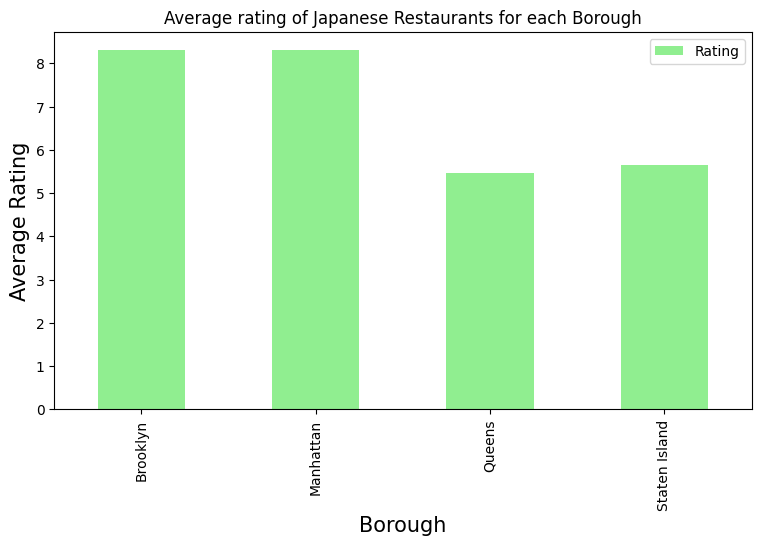

In [155]:
# Visualizing the averages

plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Japanese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color='lightgreen')
plt.legend()
plt.show()

In [156]:
# Joining the datasets to get longitute and latitude

ny_neighborhood_stats=pd.merge(japanese_rest_stats_ny,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough_x','Neighborhood','Latitude','Longitude','Rating']]
ny_neighborhood_stats

,Borough_x,Neighborhood,Latitude,Longitude,Rating
0,Brooklyn,Kensington,40.642382,-73.980421,7.9
1,Brooklyn,Prospect Heights,40.676822,-73.964859,8.1
2,Brooklyn,Williamsburg,40.707144,-73.958115,8.2
3,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,8.2
4,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.1
5,Brooklyn,Cobble Hill,40.687920,-73.998561,9.1
6,Brooklyn,Carroll Gardens,40.680540,-73.994654,7.8
7,Brooklyn,Fort Greene,40.688527,-73.972906,8.6
8,Brooklyn,Park Slope,40.672321,-73.977050,8.9
9,Brooklyn,Clinton Hill,40.693229,-73.967843,7.0


In [157]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [160]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough_x']+'('+ny_neighborhood_stats['Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

In [163]:
# set number of clusters
kclusters = 3

nyc_grouped_clustering = ny_neighborhood_stats[['Rating']]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2])

In [166]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

nyc_mergedfinal = ny_neighborhood_stats.copy()

# add clustering labels

nyc_mergedfinal['Cluster Labels'] = kmeans.labels_

print(nyc_mergedfinal.shape)

nyc_mergedfinal.head() # check the last columns!

(56, 7)


,Borough_x,Neighborhood,Latitude,Longitude,Rating,Label,Cluster Labels
0,Brooklyn,Kensington,40.642382,-73.980421,7.9,"Kensington, Brooklyn(7.9)",0
1,Brooklyn,Prospect Heights,40.676822,-73.964859,8.1,"Prospect Heights, Brooklyn(8.1)",0
2,Brooklyn,Williamsburg,40.707144,-73.958115,8.2,"Williamsburg, Brooklyn(8.2)",0
3,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,8.2,"Bedford Stuyvesant, Brooklyn(8.2)",0
4,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.1,"Brooklyn Heights, Brooklyn(8.1)",0


In [168]:
# Set manually to get proper fit in the map

address = 'NYC'
latitude = 40.642382
longitude = -73.980421

print('The geograpical coordinates of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinates of NYC are 40.642382, -73.980421.


In [172]:
map_clusters  = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
rainbow = [    'red',    'blue',    'orange',    'darkgreen',    'darkblue',    'black']
# add markers to map
markers_colors = []
for lat, lng, label1, cluster in zip(nyc_mergedfinal['Latitude'], nyc_mergedfinal['Longitude'], nyc_mergedfinal['Rating'], nyc_mergedfinal['Cluster Labels']):
    labelnew =  'Rating : {}'.format(label1)
    label = folium.Popup( labelnew, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)
map_clusters

In [176]:
# Cluster 0

nyc_mergedfinal.loc[nyc_mergedfinal['Cluster Labels'] == 0]

,Borough_x,Neighborhood,Latitude,Longitude,Rating,Label,Cluster Labels
0,Brooklyn,Kensington,40.642382,-73.980421,7.9,"Kensington, Brooklyn(7.9)",0
1,Brooklyn,Prospect Heights,40.676822,-73.964859,8.1,"Prospect Heights, Brooklyn(8.1)",0
2,Brooklyn,Williamsburg,40.707144,-73.958115,8.2,"Williamsburg, Brooklyn(8.2)",0
3,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,8.2,"Bedford Stuyvesant, Brooklyn(8.2)",0
4,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.1,"Brooklyn Heights, Brooklyn(8.1)",0
5,Brooklyn,Cobble Hill,40.687920,-73.998561,9.1,"Cobble Hill, Brooklyn(9.1)",0
6,Brooklyn,Carroll Gardens,40.680540,-73.994654,7.8,"Carroll Gardens, Brooklyn(7.8)",0
7,Brooklyn,Fort Greene,40.688527,-73.972906,8.6,"Fort Greene, Brooklyn(8.6)",0
8,Brooklyn,Park Slope,40.672321,-73.977050,8.9,"Park Slope, Brooklyn(8.9)",0
10,Brooklyn,Downtown,40.690844,-73.983463,8.9,"Downtown, Brooklyn(8.9)",0


In [177]:
# Cluster 1

nyc_mergedfinal.loc[nyc_mergedfinal['Cluster Labels'] == 1]

,Borough_x,Neighborhood,Latitude,Longitude,Rating,Label,Cluster Labels
43,Queens,Ridgewood,40.708323,-73.901435,0.0,"Ridgewood, Queens(0.0)",1
47,Queens,Little Neck,40.770826,-73.738898,0.0,"Little Neck, Queens(0.0)",1
50,Queens,Rockaway Park,40.580343,-73.841534,0.0,"Rockaway Park, Queens(0.0)",1
54,Staten Island,Eltingville,40.542231,-74.164331,0.0,"Eltingville, Staten Island(0.0)",1


In [178]:
# Cluster 2

nyc_mergedfinal.loc[nyc_mergedfinal['Cluster Labels'] == 2]

,Borough_x,Neighborhood,Latitude,Longitude,Rating,Label,Cluster Labels
9,Brooklyn,Clinton Hill,40.693229,-73.967843,7.0,"Clinton Hill, Brooklyn(7.0)",2
15,Manhattan,Chinatown,40.715618,-73.994279,7.6,"Chinatown, Manhattan(7.6)",2
30,Queens,Murray Hill,40.748303,-73.978332,7.4,"Murray Hill, Queens(7.4)",2
31,Queens,Murray Hill,40.764126,-73.812763,7.4,"Murray Hill, Queens(7.4)",2
40,Manhattan,Gramercy,40.737210,-73.981376,7.0,"Gramercy, Manhattan(7.0)",2
41,Queens,Woodside,40.746349,-73.901842,7.3,"Woodside, Queens(7.3)",2
42,Queens,Howard Beach,40.654225,-73.838138,6.7,"Howard Beach, Queens(6.7)",2
45,Queens,Rego Park,40.728974,-73.857827,6.6,"Rego Park, Queens(6.6)",2
48,Queens,Jamaica Center,40.704657,-73.796902,7.1,"Jamaica Center, Queens(7.1)",2
51,Staten Island,West Brighton,40.631879,-74.107182,6.6,"West Brighton, Staten Island(6.6)",2


# Results

In this project, It was possible to create a project that used most of the tools and methods that were studied during the course. I was able to identify a business problem, to specify the data required, to extract, prepare and visualize the data, to visualize the results and also to perform a machine learning clustering method, using K-Means and dividing the data into 3 clusters, based on their similarities, that was basically the rating each restaurant had.

The Manhattan and Brooklyn boroughs were clearly the regions with the higher rated japanese restaurants, labeled as Cluster 0 after KMeans algorithm were implemented. So, If one were to look for a good japanese restaurant, I'd recommend any neighborhood of these areas.

In other words, If a person is looking for a place to open a new Japanese restaurant, I'd recommend the boroughs of Queens or Staten Island, because besides having a small number of restaurants, the existing ones are low rated, which means these areas have potentially less competition. It's necessary to study more features, such as infrastructure, transports and wage rates of these regions, to be able to build a more robust and trustworthy model.
